In [29]:
import os
import pickle
import matplotlib.pyplot as plt
from preprocess import *
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from matplotlib import font_manager, rc


plt.rcParams['axes.unicode_minus'] = False
rc('font', family='AppleGothic')
pd.set_option('display.max_columns', None)
print(f"CPU count : {os.cpu_count()}")

CPU count : 8


### 공격수 데이터셋 로드

In [2]:
with open('datas/attack.pkl', 'rb') as f:
    attack_df = pickle.load(f)

In [3]:
attack_df = preprocess_df(attack_df)
attack_df.tail()

,market_value,app,conceded_goals,clean_sheets,yellow_card,second_yell,red_card,age,height,position,foot,club,outfitter,cup,Tackles,Inter,Fouls,Offsides,Clear,Drbed,Blocks,OwnG,Rating,Goals,Assists,SpG,Fouled,Off,Disp,UnsTch,Drb,KeyP,AvgP,PS,Crosses,LongB,ThrB,AerialsWon,MotM,period,total_out
601,1800000,10,0.100000,0.0,0.100000,0.0,0.1,26,177,Centre-Forward,right,0,adidas,0,0.2,0.1,0.8,0.0,0.0,0.5,0.0,0.0,5.95,0.000000,0.0,0.4,0.3,0.0,0.7,1.2,0.4,0.5,10.2,75.9,0.1,0.4,0.0,1.0,0.0,1.8,0.1
602,2700000,33,0.272727,0.0,0.060606,0.0,0.0,24,175,Centre-Forward,right,0,Puma,3,0.4,0.1,0.6,0.0,0.2,0.2,0.0,0.0,6.45,0.272727,0.0,0.9,1.2,0.5,0.9,2.0,0.8,0.3,8.8,77.5,0.0,0.3,0.0,0.5,0.0,3.0,0.0
603,1080000,19,0.000000,0.0,0.105263,0.0,0.0,33,182,Centre-Forward,right,0,Puma,0,0.4,0.3,0.6,0.0,0.2,0.3,0.0,0.0,6.05,0.000000,0.0,0.5,0.8,0.2,0.5,1.4,0.1,0.2,7.4,74.3,0.1,0.1,0.0,0.7,0.0,1.0,0.0
604,900000,13,0.000000,0.0,0.000000,0.0,0.0,26,192,Centre-Forward,right,0,Puma,1,0.2,0.0,0.2,0.0,0.2,0.4,0.0,0.0,6.06,0.000000,0.0,0.6,0.2,0.0,0.2,1.0,0.2,0.2,5.1,57.6,0.0,0.0,0.0,0.9,0.0,4.0,0.0
605,315000,1,0.000000,0.0,0.000000,0.0,0.0,23,185,Centre-Forward,right,0,Puma,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.17,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,50.0,0.0,0.0,0.0,1.0,0.0,5.2,0.0


#### categorical variances 더미변수화

In [7]:
model_df = pd.get_dummies(attack_df, columns=['position', 'foot', 'outfitter'])

### 초기 모델
- 범주형 : 더미변수화
- 수치형 : 전처리만 진행
- 종속변수 : original

In [8]:
dfX0 = model_df.loc[:, 'app':]
dfy = model_df['market_value']

train_X, test_X, train_y, test_y = train_test_split(dfX0, dfy, test_size=0.3, random_state=3)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(424, 48) (424,) (182, 48) (182,)


MSE :  194452715954871.66
RMSE :  13944630.362790965
r2-score :  0.5598183057492543


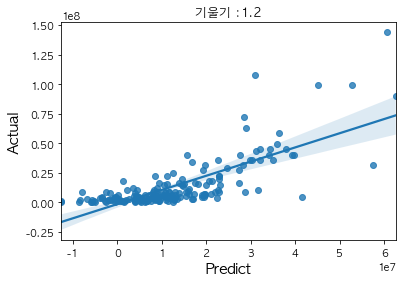

In [28]:
model_lm = LinearRegression(fit_intercept=True).fit(train_X, train_y)
pred_lm = model_lm.predict(test_X)

print("MSE : ", mean_squared_error(test_y, pred_lm))
print("RMSE : ", np.sqrt(mean_squared_error(test_y, pred_lm)))
print("r2-score : ",r2_score(test_y, pred_lm))
f = np.polyfit(pred_lm, test_y, deg=1)

sns.regplot(x=pred_lm, y=test_y)
plt.title(f"기울기 :{f[0].round(3)}")
plt.xlabel('Predict', fontsize=15)
plt.ylabel("Actual", fontsize=15)

plt.show()

### Standard, MinMax, Robust 모델 비교
- 범주형 : 더미변수화
- 수치형 : 각 스케일러 적용
- 종속변수 : original

In [30]:
ss = StandardScaler().fit(dfX0.loc[:, "app":"total_out"].values)
mm = MinMaxScaler().fit(dfX0.loc[:, "app":"total_out"].values)
rb = RobustScaler().fit(dfX0.loc[:, "app":"total_out"].values)

ss_values = ss.transform(dfX0.loc[:, "app":"total_out"].values)
mm_values = mm.transform(dfX0.loc[:, "app":"total_out"].values)
rb_values = rb.transform(dfX0.loc[:, "app":"total_out"].values)

ss_dfX0 = np.hstack([ss_values , dfX0.loc[:, "position_Centre-Forward":].values])
mm_dfX0 = np.hstack([mm_values , dfX0.loc[:, "position_Centre-Forward":].values])
rb_dfX0 = np.hstack([rb_values , dfX0.loc[:, "position_Centre-Forward":].values])

In [31]:
train_X, test_X, train_y, test_y = train_test_split(ss_dfX0, dfy, test_size=0.3, random_state=3)

ss_model = LinearRegression(fit_intercept=True).fit(train_X, train_y)
pred_ss = ss_model.predict(test_X)

print("S-scaled MSE : ", mean_squared_error(test_y, pred_ss))
print("S-scaled RMSE : ",np.sqrt(mean_squared_error(test_y, pred_ss)))
print("S-scaled r2-score : ",r2_score(test_y, pred_ss))

S-scaled MSE :  194452715954871.8
S-scaled RMSE :  13944630.36279097
S-scaled r2-score :  0.5598183057492538


In [32]:
train_X, test_X, train_y, test_y = train_test_split(mm_dfX0, dfy, test_size=0.3, random_state=3)

mm_model = LinearRegression(fit_intercept=True).fit(train_X, train_y)
pred_mm = mm_model.predict(test_X)

print("M-scaled MSE : ",mean_squared_error(test_y, pred_mm))
print("M-scaled RMSE : ",np.sqrt(mean_squared_error(test_y, pred_mm)))
print("M-scaled r2-score : ",r2_score(test_y, pred_mm))

M-scaled MSE :  454681020908745.5
M-scaled RMSE :  21323250.711576447
M-scaled r2-score :  -0.02925927850613874


In [33]:
train_X, test_X, train_y, test_y = train_test_split(rb_dfX0, dfy, test_size=0.3, random_state=3)

rb_model = LinearRegression(fit_intercept=True).fit(train_X, train_y)
pred_rb = rb_model.predict(test_X)

print("R-scaled MSE : ",mean_squared_error(test_y, pred_rb))
print("R-scaled RMSE : ",np.sqrt(mean_squared_error(test_y, pred_rb)))
print("R-scaled r2-score : ",r2_score(test_y, pred_rb))

R-scaled MSE :  194452715954871.66
R-scaled RMSE :  13944630.362790965
R-scaled r2-score :  0.5598183057492543


In [34]:
f1 = np.polyfit(pred_ss, test_y, deg=1)
f2 = np.polyfit(pred_mm, test_y, deg=1)
f3 = np.polyfit(pred_rb, test_y, deg=1)

S-scaled r2-score :  0.5598183057492538
M-scaled r2-score :  -0.02925927850613874
R-scaled r2-score :  0.5598183057492543


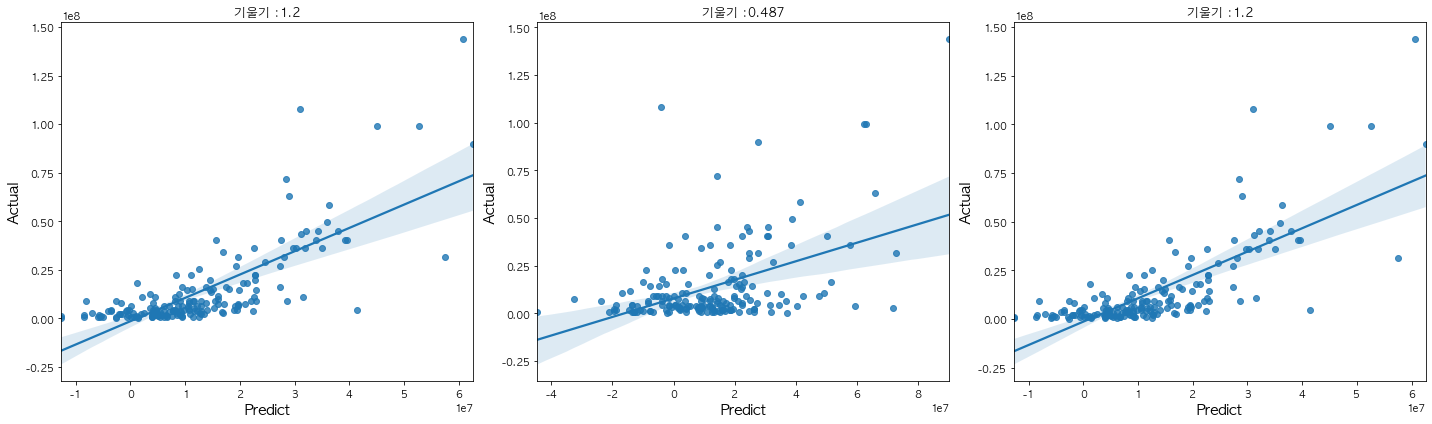

In [38]:
print("S-scaled r2-score : ",r2_score(test_y, pred_ss))
print("M-scaled r2-score : ",r2_score(test_y, pred_mm))
print("R-scaled r2-score : ",r2_score(test_y, pred_rb))

plt.figure(figsize=(20, 6))

plt.subplot(131)
sns.regplot(x=pred_ss, y=test_y)
plt.title(f"기울기 :{f1[0].round(3)}")
plt.xlabel('Predict', fontsize=15)
plt.ylabel("Actual", fontsize=15)

plt.subplot(132)
sns.regplot(x=pred_mm, y=test_y)
plt.title(f"기울기 :{f2[0].round(3)}")
plt.xlabel('Predict', fontsize=15)
plt.ylabel("Actual", fontsize=15)

plt.subplot(133)
sns.regplot(x=pred_rb, y=test_y)
plt.title(f"기울기 :{f3[0].round(3)}")
plt.xlabel('Predict', fontsize=15)
plt.ylabel("Actual", fontsize=15)

plt.tight_layout()
plt.show()

### 종속변수에 log scaling을 진행한 모델
- 범주형 : 더미변수화
- 수치형 : Standard Scaler
- 종속변수 : log1p Scaler

In [39]:
log_dfy = np.log1p(model_df['market_value'])

train_X, test_X, train_y, test_y = train_test_split(ss_dfX0, log_dfy, test_size=0.3, random_state=3)

log_scaled MSE :  0.5480264932553149
log_scaled RMSE :  0.7402881150304352
Inverse log한 RMSE :  12240363.27914449
log_scaled r2-score :  0.6854655222661425


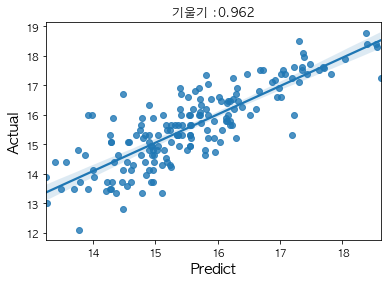

In [45]:
model_log = LinearRegression(fit_intercept=True).fit(train_X, train_y)
pred_log = model_log.predict(test_X)
f = np.polyfit(pred_log, test_y, deg=1)

print("log_scaled MSE : ", mean_squared_error(test_y, pred_log))
print("log_scaled RMSE : ",np.sqrt(mean_squared_error(test_y, pred_log)))
print("Inverse log한 RMSE : ", np.sqrt(np.sum((((np.exp(test_y) -1) - (np.exp(pred_log) -1))**2)) / len(test_y)))
print("log_scaled r2-score : ",r2_score(test_y, pred_log))

sns.regplot(x=pred_log, y=test_y)
plt.title(f"기울기 :{f[0].round(3)}")
plt.xlabel('Predict', fontsize=15)
plt.ylabel("Actual", fontsize=15)

plt.show()

### RandomForest Regessor Model 적용
- 범주형 : 더미변수화
- 수치형 : Standard Scaler
- 종속변수 : original and log1p Scaler

In [48]:
train_X, test_X, train_y, test_y = train_test_split(ss_dfX0, dfy, test_size=0.3, random_state=3)

rf_model = RandomForestRegressor().fit(train_X, train_y)
pred_rf = rf_model.predict(test_X)

print("RF MSE : ", mean_squared_error(test_y, pred_rf))
print("RF RMSE : ",np.sqrt(mean_squared_error(test_y, pred_rf)))
print("RF r2-score : ",r2_score(test_y, pred_rf))

RF MSE :  190808472615082.4
RF RMSE :  13813344.005528944
RF r2-score :  0.5680677621772257


In [49]:
train_X, test_X, train_y, test_y = train_test_split(ss_dfX0, log_dfy, test_size=0.3, random_state=3)

rf_log_model = RandomForestRegressor().fit(train_X, train_y)
pred_rf_log = rf_log_model.predict(test_X)

print("log_RF MSE : ", mean_squared_error(test_y, pred_rf_log))
print("log_RF RMSE : ",np.sqrt(mean_squared_error(test_y, pred_rf_log)))
print("log_RF r2-score : ",r2_score(test_y, pred_rf_log))

log_RF MSE :  0.5679091803250554
log_RF RMSE :  0.7535974922497125
log_RF r2-score :  0.6740540473276251


### GridSearchCV를 통한 best hyper parameter 추출
- model : RandomForest Regessor
- 범주형 : 더미변수화
- 수치형 : Standard Scaler
- 종속변수 : log1p Scaler

In [114]:
random_params = {'bootstrap': [True, False],
 'max_depth': [1,3,5,7,9],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800]}

result = GridSearchCV(
    RandomForestRegressor(),
    param_grid=random_params,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=3)

result.fit(train_X, train_y)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
[CV 1/5] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-1.022 total time=   0.1s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-1.316 total time=   0.1s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-0.894 total time=   0.1s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-1.253 total time=   0.1s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-1.205 total time=   0.1s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-1.022 total time=   0.2s
[CV 2/5] END boots

[CV 5/5] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=600;, score=-1.196 total time=   0.3s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800;, score=-1.019 total time=   0.5s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800;, score=-1.323 total time=   0.5s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800;, score=-0.900 total time=   0.5s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800;, score=-1.254 total time=   0.5s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800;, score=-1.207 total time=   0.5s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=auto, min_samples_lea

[CV 4/5] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-1.265 total time=   0.2s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-1.197 total time=   0.2s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-1.026 total time=   0.3s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-1.319 total time=   0.3s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.907 total time=   0.3s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-1.260 total time=   0.3s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=auto, min_samples_lea

[CV 4/5] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=-1.268 total time=   0.1s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=-1.203 total time=   0.1s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=-1.032 total time=   0.2s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=-1.326 total time=   0.2s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=-0.902 total time=   0.2s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=-1.258 total time=   0.2s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=auto, min_samples_lea

[CV 3/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800;, score=-0.965 total time=   0.3s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800;, score=-1.367 total time=   0.3s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800;, score=-1.290 total time=   0.3s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-1.125 total time=   0.1s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-1.460 total time=   0.1s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-0.981 total time=   0.1s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1

[CV 2/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600;, score=-1.454 total time=   0.2s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600;, score=-0.966 total time=   0.2s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600;, score=-1.376 total time=   0.2s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600;, score=-1.287 total time=   0.2s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-1.110 total time=   0.3s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-1.469 total time=   0.3s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, m

[CV 1/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400;, score=-1.109 total time=   0.2s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400;, score=-1.466 total time=   0.2s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400;, score=-0.969 total time=   0.2s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400;, score=-1.366 total time=   0.2s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400;, score=-1.283 total time=   0.2s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600;, score=-1.123 total time=   0.2s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, m

[CV 5/5] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-0.852 total time=   0.8s
[CV 1/5] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-0.721 total time=   0.2s
[CV 2/5] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-0.909 total time=   0.2s
[CV 3/5] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-0.623 total time=   0.2s
[CV 4/5] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-0.813 total time=   0.2s
[CV 5/5] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-0.836 total time=   0.2s
[CV 1/5] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, m

[CV 4/5] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600;, score=-0.822 total time=   0.6s
[CV 5/5] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600;, score=-0.851 total time=   0.6s
[CV 1/5] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-0.714 total time=   0.8s
[CV 2/5] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-0.915 total time=   0.8s
[CV 3/5] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-0.631 total time=   0.8s
[CV 4/5] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-0.818 total time=   0.8s
[CV 5/5] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, m

[CV 3/5] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400;, score=-0.612 total time=   0.4s
[CV 4/5] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400;, score=-0.823 total time=   0.4s
[CV 5/5] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400;, score=-0.847 total time=   0.4s
[CV 1/5] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=-0.723 total time=   0.6s
[CV 2/5] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=-0.915 total time=   0.6s
[CV 3/5] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=-0.598 total time=   0.6s
[CV 4/5] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, m

[CV 3/5] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-0.670 total time=   0.1s
[CV 4/5] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-0.971 total time=   0.1s
[CV 5/5] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-0.986 total time=   0.1s
[CV 1/5] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.835 total time=   0.2s
[CV 2/5] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-1.117 total time=   0.2s
[CV 3/5] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.664 total time=   0.2s
[CV 4/5] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, m

[CV 2/5] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800;, score=-1.119 total time=   0.4s
[CV 3/5] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800;, score=-0.677 total time=   0.4s
[CV 4/5] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800;, score=-0.958 total time=   0.4s
[CV 5/5] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800;, score=-0.971 total time=   0.4s
[CV 1/5] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=-0.802 total time=   0.1s
[CV 2/5] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=-1.109 total time=   0.1s
[CV 3/5] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=

[CV 1/5] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.816 total time=   0.3s
[CV 2/5] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-1.100 total time=   0.3s
[CV 3/5] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.677 total time=   0.3s
[CV 4/5] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.959 total time=   0.3s
[CV 5/5] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.968 total time=   0.3s
[CV 1/5] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800;, score=-0.830 total time=   0.4s
[CV 2/5] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_lea

[CV 1/5] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=-0.826 total time=   0.2s
[CV 2/5] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=-1.095 total time=   0.2s
[CV 3/5] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=-0.677 total time=   0.2s
[CV 4/5] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=-0.949 total time=   0.2s
[CV 5/5] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=-0.979 total time=   0.2s
[CV 1/5] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=-0.835 total time=   0.3s
[CV 2/5] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_lea

[CV 5/5] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800;, score=-0.727 total time=   1.1s
[CV 1/5] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-0.680 total time=   0.3s
[CV 2/5] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-0.815 total time=   0.3s
[CV 3/5] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-0.554 total time=   0.3s
[CV 4/5] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-0.763 total time=   0.3s
[CV 5/5] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-0.743 total time=   0.3s
[CV 1/5] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf

[CV 4/5] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600;, score=-0.749 total time=   0.8s
[CV 5/5] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600;, score=-0.728 total time=   0.8s
[CV 1/5] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.672 total time=   1.1s
[CV 2/5] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.802 total time=   1.1s
[CV 3/5] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.569 total time=   1.1s
[CV 4/5] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.753 total time=   1.1s
[CV 5/5] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, m

[CV 3/5] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400;, score=-0.556 total time=   0.5s
[CV 4/5] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400;, score=-0.752 total time=   0.5s
[CV 5/5] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400;, score=-0.742 total time=   0.5s
[CV 1/5] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600;, score=-0.696 total time=   0.8s
[CV 2/5] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600;, score=-0.802 total time=   0.8s
[CV 3/5] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600;, score=-0.564 total time=   0.8s
[CV 4/5] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, m

[CV 2/5] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-0.954 total time=   0.1s
[CV 3/5] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-0.592 total time=   0.1s
[CV 4/5] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-0.875 total time=   0.1s
[CV 5/5] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-0.863 total time=   0.1s
[CV 1/5] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=-0.758 total time=   0.2s
[CV 2/5] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=-0.969 total time=   0.2s
[CV 3/5] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, m

[CV 1/5] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-0.756 total time=   0.4s
[CV 2/5] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-0.971 total time=   0.4s
[CV 3/5] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-0.584 total time=   0.4s
[CV 4/5] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-0.858 total time=   0.4s
[CV 5/5] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-0.868 total time=   0.4s
[CV 1/5] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=-0.757 total time=   0.1s
[CV 2/5] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, m

[CV 5/5] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400;, score=-0.869 total time=   0.2s
[CV 1/5] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=-0.756 total time=   0.3s
[CV 2/5] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=-0.980 total time=   0.3s
[CV 3/5] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=-0.592 total time=   0.3s
[CV 4/5] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=-0.846 total time=   0.3s
[CV 5/5] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=-0.874 total time=   0.3s
[CV 1/5] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, m

[CV 4/5] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-0.740 total time=   0.4s
[CV 5/5] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-0.680 total time=   0.4s
[CV 1/5] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.659 total time=   0.7s
[CV 2/5] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.780 total time=   0.7s
[CV 3/5] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.563 total time=   0.7s
[CV 4/5] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.736 total time=   0.7s
[CV 5/5] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, m

[CV 3/5] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800;, score=-0.556 total time=   1.2s
[CV 4/5] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800;, score=-0.741 total time=   1.2s
[CV 5/5] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800;, score=-0.701 total time=   1.2s
[CV 1/5] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=-0.681 total time=   0.3s
[CV 2/5] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=-0.781 total time=   0.3s
[CV 3/5] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=-0.552 total time=   0.3s
[CV 4/5] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2

[CV 2/5] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.773 total time=   0.9s
[CV 3/5] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.556 total time=   0.9s
[CV 4/5] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.738 total time=   0.9s
[CV 5/5] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.719 total time=   0.9s
[CV 1/5] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800;, score=-0.676 total time=   1.2s
[CV 2/5] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800;, score=-0.777 total time=   1.3s
[CV 3/5] END bootstrap=True, max_depth=7, max_features=auto, min_samples_lea

[CV 1/5] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=-0.690 total time=   0.6s
[CV 2/5] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=-0.800 total time=   0.6s
[CV 3/5] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=-0.555 total time=   0.6s
[CV 4/5] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=-0.739 total time=   0.6s
[CV 5/5] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=-0.724 total time=   0.6s
[CV 1/5] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=-0.684 total time=   0.9s
[CV 2/5] END bootstrap=True, max_depth=7, max_features=auto, min_samples_lea

[CV 5/5] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800;, score=-0.805 total time=   0.5s
[CV 1/5] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-0.729 total time=   0.1s
[CV 2/5] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-0.934 total time=   0.1s
[CV 3/5] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-0.572 total time=   0.1s
[CV 4/5] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-0.825 total time=   0.1s
[CV 5/5] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-0.813 total time=   0.1s
[CV 1/5] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf

[CV 4/5] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600;, score=-0.824 total time=   0.3s
[CV 5/5] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600;, score=-0.816 total time=   0.3s
[CV 1/5] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.727 total time=   0.4s
[CV 2/5] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.930 total time=   0.4s
[CV 3/5] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.559 total time=   0.5s
[CV 4/5] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.827 total time=   0.5s
[CV 5/5] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, m

[CV 3/5] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400;, score=-0.583 total time=   0.2s
[CV 4/5] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400;, score=-0.832 total time=   0.2s
[CV 5/5] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400;, score=-0.829 total time=   0.2s
[CV 1/5] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600;, score=-0.753 total time=   0.3s
[CV 2/5] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600;, score=-0.954 total time=   0.3s
[CV 3/5] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600;, score=-0.571 total time=   0.3s
[CV 4/5] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, m

[CV 2/5] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-0.792 total time=   0.4s
[CV 3/5] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-0.539 total time=   0.4s
[CV 4/5] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-0.742 total time=   0.4s
[CV 5/5] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-0.706 total time=   0.4s
[CV 1/5] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=-0.674 total time=   0.7s
[CV 2/5] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=-0.783 total time=   0.8s
[CV 3/5] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, m

[CV 1/5] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-0.668 total time=   1.4s
[CV 2/5] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-0.771 total time=   1.4s
[CV 3/5] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-0.559 total time=   1.5s
[CV 4/5] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-0.741 total time=   1.5s
[CV 5/5] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-0.695 total time=   1.5s
[CV 1/5] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=-0.662 total time=   0.4s
[CV 2/5] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, m

[CV 5/5] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400;, score=-0.721 total time=   0.6s
[CV 1/5] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=-0.680 total time=   1.0s
[CV 2/5] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=-0.788 total time=   1.0s
[CV 3/5] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=-0.558 total time=   1.0s
[CV 4/5] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=-0.752 total time=   1.0s
[CV 5/5] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=-0.718 total time=   1.0s
[CV 1/5] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, m

[CV 4/5] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-0.812 total time=   0.1s
[CV 5/5] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-0.811 total time=   0.1s
[CV 1/5] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.724 total time=   0.3s
[CV 2/5] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.902 total time=   0.3s
[CV 3/5] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.547 total time=   0.3s
[CV 4/5] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.829 total time=   0.3s
[CV 5/5] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, m

[CV 3/5] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800;, score=-0.566 total time=   0.5s
[CV 4/5] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800;, score=-0.827 total time=   0.5s
[CV 5/5] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800;, score=-0.819 total time=   0.5s
[CV 1/5] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=-0.725 total time=   0.1s
[CV 2/5] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=-0.918 total time=   0.1s
[CV 3/5] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=-0.552 total time=   0.1s
[CV 4/5] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2

[CV 2/5] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.917 total time=   0.4s
[CV 3/5] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.575 total time=   0.4s
[CV 4/5] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.822 total time=   0.4s
[CV 5/5] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.840 total time=   0.4s
[CV 1/5] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800;, score=-0.742 total time=   0.5s
[CV 2/5] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800;, score=-0.926 total time=   0.5s
[CV 3/5] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_lea

[CV 1/5] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=-0.750 total time=   0.2s
[CV 2/5] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=-0.942 total time=   0.2s
[CV 3/5] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=-0.583 total time=   0.2s
[CV 4/5] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=-0.823 total time=   0.2s
[CV 5/5] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=-0.839 total time=   0.2s
[CV 1/5] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=-0.748 total time=   0.4s
[CV 2/5] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_lea

[CV 5/5] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800;, score=-1.250 total time=   0.5s
[CV 1/5] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-1.249 total time=   0.1s
[CV 2/5] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-1.508 total time=   0.1s
[CV 3/5] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-1.031 total time=   0.1s
[CV 4/5] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-1.538 total time=   0.1s
[CV 5/5] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-1.250 total time=   0.1s
[CV 1/5] END bootstrap=False, max_depth=1, max_features=auto, min_sampl

[CV 4/5] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600;, score=-1.538 total time=   0.3s
[CV 5/5] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600;, score=-1.250 total time=   0.3s
[CV 1/5] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-1.249 total time=   0.4s
[CV 2/5] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-1.508 total time=   0.5s
[CV 3/5] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-1.031 total time=   0.5s
[CV 4/5] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-1.538 total time=   0.5s
[CV 5/5] END bootstrap=False, max_depth=1, max_features=auto, min_samples_le

[CV 3/5] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400;, score=-1.031 total time=   0.2s
[CV 4/5] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400;, score=-1.538 total time=   0.2s
[CV 5/5] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400;, score=-1.250 total time=   0.2s
[CV 1/5] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600;, score=-1.249 total time=   0.3s
[CV 2/5] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600;, score=-1.508 total time=   0.3s
[CV 3/5] END bootstrap=False, max_depth=1, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600;, score=-1.031 total time=   0.3s
[CV 4/5] END bootstrap=False, max_depth=1, max_features=auto, min_samples_le

[CV 4/5] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-1.372 total time=   0.1s
[CV 5/5] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-1.273 total time=   0.1s
[CV 1/5] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=-1.125 total time=   0.1s
[CV 2/5] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=-1.463 total time=   0.1s
[CV 3/5] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=-0.979 total time=   0.1s
[CV 4/5] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=-1.381 total time=   0.1s
[CV 5/5] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_le

[CV 3/5] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-0.980 total time=   0.2s
[CV 4/5] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-1.385 total time=   0.2s
[CV 5/5] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-1.293 total time=   0.3s
[CV 1/5] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=-1.131 total time=   0.1s
[CV 2/5] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=-1.448 total time=   0.1s
[CV 3/5] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=-0.975 total time=   0.1s
[CV 4/5] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_le

[CV 3/5] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=-0.984 total time=   0.2s
[CV 4/5] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=-1.387 total time=   0.2s
[CV 5/5] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=-1.298 total time=   0.2s
[CV 1/5] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800;, score=-1.142 total time=   0.2s
[CV 2/5] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800;, score=-1.470 total time=   0.3s
[CV 3/5] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800;, score=-0.972 total time=   0.3s
[CV 4/5] END bootstrap=False, max_depth=1, max_features=sqrt, min_samples_le

[CV 2/5] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-1.257 total time=   0.5s
[CV 3/5] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-1.029 total time=   0.5s
[CV 4/5] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-1.237 total time=   0.5s
[CV 5/5] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-1.196 total time=   0.5s
[CV 1/5] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.953 total time=   0.7s
[CV 2/5] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-1.257 total time=   0.7s
[CV 3/5] END bootstrap=False, max_depth=3, max_features=auto, min_samples_le

[CV 1/5] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=-0.953 total time=   0.2s
[CV 2/5] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=-1.257 total time=   0.2s
[CV 3/5] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=-1.029 total time=   0.2s
[CV 4/5] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=-1.237 total time=   0.2s
[CV 5/5] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=-1.196 total time=   0.2s
[CV 1/5] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=-0.953 total time=   0.5s
[CV 2/5] END bootstrap=False, max_depth=3, max_features=auto, min_samples_le

[CV 5/5] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-1.196 total time=   0.7s
[CV 1/5] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800;, score=-0.953 total time=   0.9s
[CV 2/5] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800;, score=-1.257 total time=   0.9s
[CV 3/5] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800;, score=-1.029 total time=   0.9s
[CV 4/5] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800;, score=-1.237 total time=   0.9s
[CV 5/5] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800;, score=-1.196 total time=   0.9s
[CV 1/5] END bootstrap=False, max_depth=3, max_features=auto, min_samp

[CV 4/5] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=-1.237 total time=   0.5s
[CV 5/5] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=-1.052 total time=   0.5s
[CV 1/5] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=-0.953 total time=   0.7s
[CV 2/5] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=-1.257 total time=   0.7s
[CV 3/5] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=-1.029 total time=   0.7s
[CV 4/5] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=-1.237 total time=   0.7s
[CV 5/5] END bootstrap=False, max_depth=3, max_features=auto, min_samp

[CV 3/5] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-0.677 total time=   0.1s
[CV 4/5] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-0.949 total time=   0.1s
[CV 5/5] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-0.975 total time=   0.1s
[CV 1/5] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400;, score=-0.818 total time=   0.2s
[CV 2/5] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400;, score=-1.101 total time=   0.2s
[CV 3/5] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400;, score=-0.671 total time=   0.2s
[CV 4/5] END bootstrap=False, max_depth=3, max_features=sqrt, min_samp

[CV 2/5] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-1.085 total time=   0.3s
[CV 3/5] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.668 total time=   0.3s
[CV 4/5] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.951 total time=   0.3s
[CV 5/5] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.960 total time=   0.3s
[CV 1/5] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.814 total time=   0.1s
[CV 2/5] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-1.092 total time=   0.1s
[CV 3/5] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_

[CV 1/5] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600;, score=-0.816 total time=   0.2s
[CV 2/5] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600;, score=-1.084 total time=   0.2s
[CV 3/5] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600;, score=-0.682 total time=   0.2s
[CV 4/5] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600;, score=-0.958 total time=   0.2s
[CV 5/5] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600;, score=-0.960 total time=   0.2s
[CV 1/5] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800;, score=-0.813 total time=   0.3s
[CV 2/5] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_le

[CV 5/5] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-1.251 total time=   0.3s
[CV 1/5] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=-1.140 total time=   0.7s
[CV 2/5] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=-1.109 total time=   0.7s
[CV 3/5] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=-1.163 total time=   0.7s
[CV 4/5] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=-1.153 total time=   0.7s
[CV 5/5] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=-1.269 total time=   0.7s
[CV 1/5] END bootstrap=False, max_depth=5, max_features=auto, min_samples_le

[CV 4/5] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-1.151 total time=   1.4s
[CV 5/5] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-1.180 total time=   1.4s
[CV 1/5] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=-1.138 total time=   0.4s
[CV 2/5] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=-1.115 total time=   0.4s
[CV 3/5] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=-1.133 total time=   0.4s
[CV 4/5] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=-1.150 total time=   0.4s
[CV 5/5] END bootstrap=False, max_depth=5, max_features=auto, min_samples_le

[CV 3/5] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=-1.142 total time=   1.0s
[CV 4/5] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=-1.387 total time=   1.0s
[CV 5/5] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=-1.121 total time=   1.0s
[CV 1/5] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=800;, score=-1.196 total time=   1.4s
[CV 2/5] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=800;, score=-1.249 total time=   1.4s
[CV 3/5] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=800;, score=-1.142 total time=   1.4s
[CV 4/5] END bootstrap=False, max_depth=5, max_features=auto, min_samples_le

[CV 3/5] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.594 total time=   0.2s
[CV 4/5] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.839 total time=   0.2s
[CV 5/5] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.830 total time=   0.2s
[CV 1/5] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.744 total time=   0.3s
[CV 2/5] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.938 total time=   0.3s
[CV 3/5] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-0.591 total time=   0.3s
[CV 4/5] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_le

[CV 3/5] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=-0.586 total time=   0.1s
[CV 4/5] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=-0.835 total time=   0.1s
[CV 5/5] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=-0.831 total time=   0.1s
[CV 1/5] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=-0.735 total time=   0.2s
[CV 2/5] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=-0.934 total time=   0.2s
[CV 3/5] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=-0.592 total time=   0.2s
[CV 4/5] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_le

[CV 2/5] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800;, score=-0.948 total time=   0.4s
[CV 3/5] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800;, score=-0.582 total time=   0.4s
[CV 4/5] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800;, score=-0.835 total time=   0.4s
[CV 5/5] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800;, score=-0.834 total time=   0.4s
[CV 1/5] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=-0.729 total time=   0.1s
[CV 2/5] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=-0.943 total time=   0.1s
[CV 3/5] END bootstrap=False, max_depth=5, max_features=sqrt, min_sample

[CV 1/5] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=-0.742 total time=   0.3s
[CV 2/5] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=-0.943 total time=   0.3s
[CV 3/5] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=-0.586 total time=   0.3s
[CV 4/5] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=-0.829 total time=   0.3s
[CV 5/5] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=-0.841 total time=   0.3s
[CV 1/5] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800;, score=-0.754 total time=   0.4s
[CV 2/5] END bootstrap=False, max_depth=5, max_features=sqrt, min_samp

[CV 5/5] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-1.298 total time=   0.4s
[CV 1/5] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400;, score=-1.374 total time=   0.9s
[CV 2/5] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400;, score=-1.233 total time=   0.9s
[CV 3/5] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400;, score=-1.134 total time=   0.9s
[CV 4/5] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400;, score=-1.358 total time=   0.9s
[CV 5/5] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400;, score=-1.294 total time=   0.9s
[CV 1/5] END bootstrap=False, max_depth=7, max_features=auto, min_samp

[CV 4/5] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-1.369 total time=   1.8s
[CV 5/5] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-1.362 total time=   1.8s
[CV 1/5] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-1.352 total time=   0.4s
[CV 2/5] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-1.232 total time=   0.4s
[CV 3/5] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-1.050 total time=   0.4s
[CV 4/5] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-1.345 total time=   0.4s
[CV 5/5] END bootstrap=False, max_depth=7, max_features=auto, min_sample

[CV 3/5] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600;, score=-1.181 total time=   1.3s
[CV 4/5] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600;, score=-1.428 total time=   1.3s
[CV 5/5] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600;, score=-1.191 total time=   1.3s
[CV 1/5] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800;, score=-1.293 total time=   1.7s
[CV 2/5] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800;, score=-1.336 total time=   1.7s
[CV 3/5] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800;, score=-1.181 total time=   1.7s
[CV 4/5] END bootstrap=False, max_depth=7, max_features=auto, min_samples_le

[CV 2/5] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=-0.863 total time=   0.2s
[CV 3/5] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=-0.553 total time=   0.2s
[CV 4/5] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=-0.813 total time=   0.2s
[CV 5/5] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=-0.767 total time=   0.2s
[CV 1/5] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600;, score=-0.719 total time=   0.3s
[CV 2/5] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600;, score=-0.893 total time=   0.3s
[CV 3/5] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_le

[CV 2/5] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=-0.921 total time=   0.1s
[CV 3/5] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=-0.555 total time=   0.1s
[CV 4/5] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=-0.791 total time=   0.1s
[CV 5/5] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=-0.781 total time=   0.1s
[CV 1/5] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400;, score=-0.728 total time=   0.2s
[CV 2/5] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400;, score=-0.880 total time=   0.2s
[CV 3/5] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_le

[CV 1/5] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800;, score=-0.731 total time=   0.4s
[CV 2/5] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800;, score=-0.900 total time=   0.4s
[CV 3/5] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800;, score=-0.557 total time=   0.4s
[CV 4/5] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800;, score=-0.806 total time=   0.4s
[CV 5/5] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800;, score=-0.795 total time=   0.4s
[CV 1/5] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=-0.733 total time=   0.1s
[CV 2/5] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_le

[CV 5/5] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-1.351 total time=   1.1s
[CV 1/5] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-1.240 total time=   1.7s
[CV 2/5] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-1.462 total time=   1.7s
[CV 3/5] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-1.431 total time=   1.7s
[CV 4/5] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-1.394 total time=   1.7s
[CV 5/5] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=-1.355 total time=   1.7s
[CV 1/5] END bootstrap=False, max_depth=9, max_features=auto, min_samples_le

[CV 4/5] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=-1.563 total time=   0.5s
[CV 5/5] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=-1.380 total time=   0.5s
[CV 1/5] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=-1.239 total time=   1.1s
[CV 2/5] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=-1.503 total time=   1.1s
[CV 3/5] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=-1.302 total time=   1.1s
[CV 4/5] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=-1.563 total time=   1.1s
[CV 5/5] END bootstrap=False, max_depth=9, max_features=auto, min_samples_le

[CV 3/5] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800;, score=-1.191 total time=   2.0s
[CV 4/5] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800;, score=-1.502 total time=   2.0s
[CV 5/5] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800;, score=-1.359 total time=   2.0s
[CV 1/5] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=-1.347 total time=   0.5s
[CV 2/5] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=-1.398 total time=   0.5s
[CV 3/5] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=-1.283 total time=   0.5s
[CV 4/5] END bootstrap=False, max_depth=9, max_features=auto, min_samples

[CV 2/5] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=-1.372 total time=   1.4s
[CV 3/5] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=-1.244 total time=   1.4s
[CV 4/5] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=-1.445 total time=   1.3s
[CV 5/5] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=-1.162 total time=   1.4s
[CV 1/5] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=800;, score=-1.400 total time=   1.8s
[CV 2/5] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=800;, score=-1.373 total time=   1.8s
[CV 3/5] END bootstrap=False, max_depth=9, max_features=auto, min_samp

[CV 1/5] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400;, score=-0.709 total time=   0.2s
[CV 2/5] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400;, score=-0.871 total time=   0.2s
[CV 3/5] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400;, score=-0.554 total time=   0.2s
[CV 4/5] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400;, score=-0.785 total time=   0.2s
[CV 5/5] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400;, score=-0.783 total time=   0.2s
[CV 1/5] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600;, score=-0.716 total time=   0.3s
[CV 2/5] END bootstrap=False, max_depth=9, max_features=sqrt, min_samp

[CV 5/5] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.769 total time=   0.5s
[CV 1/5] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.731 total time=   0.1s
[CV 2/5] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.880 total time=   0.1s
[CV 3/5] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.552 total time=   0.1s
[CV 4/5] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.793 total time=   0.1s
[CV 5/5] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.778 total time=   0.1s
[CV 1/5] END bootstrap=False, max_depth=9, max_features=sqrt, min_sampl

[CV 4/5] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600;, score=-0.795 total time=   0.3s
[CV 5/5] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600;, score=-0.797 total time=   0.3s
[CV 1/5] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800;, score=-0.711 total time=   0.5s
[CV 2/5] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800;, score=-0.891 total time=   0.5s
[CV 3/5] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800;, score=-0.552 total time=   0.5s
[CV 4/5] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800;, score=-0.803 total time=   0.4s
[CV 5/5] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_le

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [1, 3, 5, 7, 9],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 400, 600, 800]},
             scoring='neg_mean_squared_error', verbose=3)

In [115]:
result.best_params_

{'bootstrap': True,
 'max_depth': 9,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

In [50]:
params = {
    'bootstrap': True,
    'max_depth': 9,
    'max_features': 'auto',
    'min_samples_leaf': 2,
    'min_samples_split': 2,
    'n_estimators': 200
         }

In [51]:
grid_model = RandomForestRegressor(**params).fit(train_X, train_y)
pred_grid = grid_model.predict(test_X)

print(mean_squared_error(test_y, pred_grid))
print(np.sqrt(mean_squared_error(test_y, pred_grid)))
print(r2_score(test_y, pred_grid))

0.5758052159452572
0.758818302326227
0.669522194450923


### Pipeline을 이용한 Model 생성
- ploynomialFeatures을 이용한 다향회귀 진행 : 삼차항
- pipeline : `PolynomialFeatures > StandardScaler > RandomForestRegressor`
- 범주형 : 더미변수화
- 수치형 : Standard Scaler
- 종속변수 : log1p Scaler

In [32]:
pipe = Pipeline([
    ('ploy', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor())
])

pipe_params = {
#     'ploy__degree': [3],
#     'rf__bootstrap': [True],
#     'rf__max_features': ['auto', 'sqrt'],
    'rf__min_samples_leaf': [2, 4, 8],
    'rf__min_samples_split': [2, 4, 8],
    'rf__n_estimators': [200, 1000]
}

pipe_grid = HalvingGridSearchCV(pipe, param_grid=pipe_params, verbose=2, n_jobs=os.cpu_count()-2,
                                scoring="roc_auc", min_resources="exhaust", cv=3)
pipe_grid.fit(train_X, train_y)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 47
max_resources_: 424
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 18
n_resources: 47
Fitting 3 folds for each of 18 candidates, totalling 54 fits
----------
iter: 1
n_candidates: 6
n_resources: 141
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 2
n_candidates: 2
n_resources: 423
Fitting 3 folds for each of 2 candidates, totalling 6 fits


HalvingGridSearchCV(cv=3,
                    estimator=Pipeline(steps=[('ploy',
                                               PolynomialFeatures(degree=3)),
                                              ('scaler', StandardScaler()),
                                              ('rf', RandomForestRegressor())]),
                    n_jobs=6,
                    param_grid={'rf__min_samples_leaf': [2, 4, 8],
                                'rf__min_samples_split': [2, 4, 8],
                                'rf__n_estimators': [200, 1000]},
                    refit=<function _refit_callable at 0x144d21a60>,
                    scoring='roc_auc', verbose=2)

In [35]:
ploy3_params = pipe_grid.best_params_
ploy3_params

{'rf__min_samples_leaf': 8,
 'rf__min_samples_split': 8,
 'rf__n_estimators': 200}

In [38]:
pipe_2 = Pipeline([
    ('ploy', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(min_samples_leaf=8,
                                min_impurity_split=8,
                                n_estimators=200))
])

result_2 = pipe_2.fit(train_X, train_y)
pred_2 = result_2.predict(test_X)

print(mean_squared_error(test_y, pred_2))
print(np.sqrt(mean_squared_error(test_y, pred_2)))
print(r2_score(test_y, pred_2))

1.76123658122516
1.327115888393007
-0.010844612549300248


### 최종 모델 선정 및 OLS객체를 통한 통계분석
- model : LinearRegression
- 범주형 : 더미변수화
- 수치형 : Standard Scaler
- 종속변수 : log1p Scaler

In [52]:
train_X, test_X, train_y, test_y1 = train_test_split(dfX0, dfy, test_size=0.3, random_state=3)
train_X, test_X, train_y, test_y2 = train_test_split(ss_dfX0, log_dfy, test_size=0.3, random_state=3)

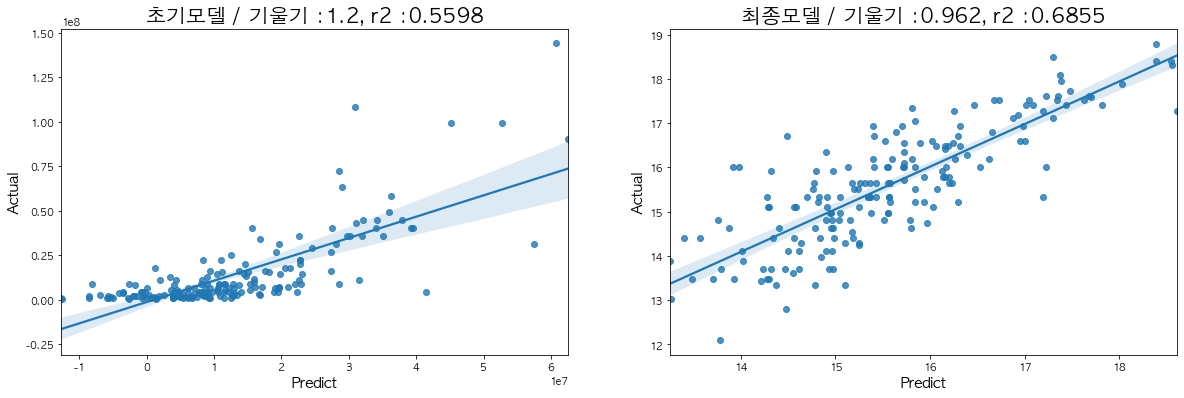

In [61]:
f1 = np.polyfit(pred_lm, test_y1, deg=1)
f2 = np.polyfit(pred_log, test_y2, deg=1)

plt.figure(figsize=(20, 6))

plt.subplot(121)
sns.regplot(x=pred_lm, y=test_y1)
plt.title(f"초기모델 / 기울기 :{f1[0].round(3)}, r2 :{np.round(r2_score(test_y1, pred_lm), 4)}", fontsize=20)
plt.xlabel('Predict', fontsize=15)
plt.ylabel("Actual", fontsize=15)

plt.subplot(122)
sns.regplot(x=pred_log, y=test_y2)
plt.title(f"최종모델 / 기울기 :{f2[0].round(3)}, r2 :{np.round(r2_score(test_y2, pred_log), 4)}", fontsize=20)
plt.xlabel('Predict', fontsize=15)
plt.ylabel("Actual", fontsize=15)

plt.show()

In [62]:
import statsmodels.api as sm

In [69]:
StandardScaler().fit_transform(dfX0)

array([[ 0.75817174,  0.84180689,  1.66834513, ..., -0.28660575,
        -0.82381452,  5.15222811],
       [ 0.44688985,  0.83529521,  0.85002956, ..., -0.28660575,
        -0.82381452, -0.19409079],
       [ 0.03184732,  0.66707691, -0.13036784, ..., -0.28660575,
         1.21386547, -0.19409079],
       ...,
       [-0.48695583, -0.98146248, -0.98821556, ...,  3.4891135 ,
        -0.82381452, -0.19409079],
       [-1.10951962, -0.98146248, -0.98821556, ...,  3.4891135 ,
        -0.82381452, -0.19409079],
       [-2.35464719, -0.98146248, -0.98821556, ...,  3.4891135 ,
        -0.82381452, -0.19409079]])

In [70]:
X0 = pd.DataFrame(StandardScaler().fit_transform(dfX0), columns=dfX0.columns)
X1 = sm.add_constant(X0)
y = log_dfy

final_model = sm.OLS(y, X1).fit()
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:           market_value   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     27.84
Date:                Fri, 11 Jun 2021   Prob (F-statistic):          3.54e-113
Time:                        17:40:07   Log-Likelihood:                -687.61
No. Observations:                 606   AIC:                             1465.
Df Residuals:                     561   BIC:                             1664.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [95]:
# p-value <= 0.1인 index 추출
idx = final_model.pvalues[1:] <= 0.1

final_model.params[1:][idx]

app               0.165288
conceded_goals   -0.214899
yellow_card      -0.069854
age              -0.314128
club              0.308020
cup               0.138083
Goals             0.327745
SpG               0.394476
AvgP              0.157358
PS                0.124564
MotM             -0.146729
period            0.274621
dtype: float64

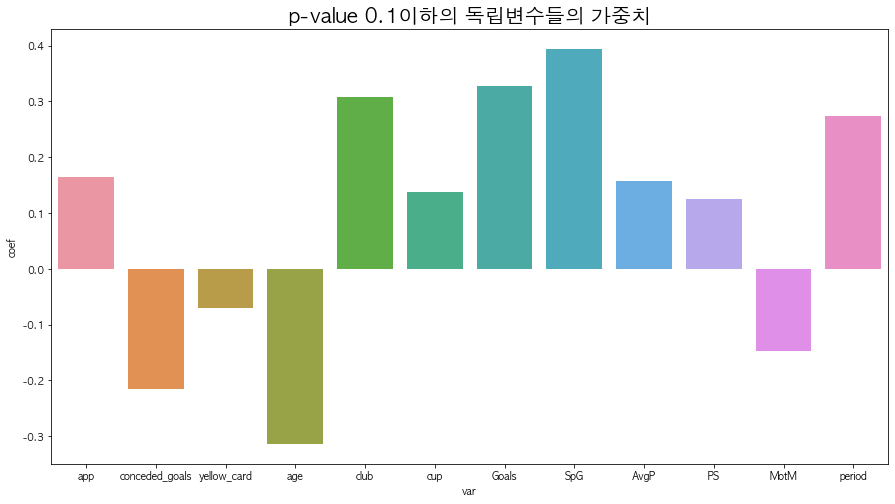

In [104]:
result_df = final_model.params[1:][idx].reset_index().rename(columns={"index": "var", 0: "coef"})

plt.figure(figsize=(15, 8))

sns.barplot(data=result_df, x='var', y='coef')
plt.title("p-value 0.1이하의 독립변수들의 가중치", fontsize=20)

plt.show()